Import and Configure GPU Memory Growth

In [1]:
import tensorflow as tf
from tensorflow.python.client import device_lib

# Check if GPU is available and set memory growth
gpus = len(tf.test.gpu_device_name())
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(f"{len(gpus)} Physical GPUs, {len(logical_gpus)} Logical GPUs")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU available")

# Print TensorFlow version and device details
print("TensorFlow Version: ", tf.__version__)
print(device_lib.list_local_devices())

No GPU available
TensorFlow Version:  2.10.0
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6005609442664686077
xla_global_id: -1
]


Load DataFrames and PreProcess

In [2]:
import os
import pandas as pd

# Load all CSV files from "etfs" and "stocks" directories
data_dir_etfs = './data/etfs'
data_dir_stocks = './data/stocks'

all_files = []
for directory in [data_dir_stocks, data_dir_etfs]:
    for file in os.listdir(directory):
        if file.endswith('.csv'):
            all_files.append(os.path.join(directory, file))

# Concatenate all data into a single DataFrame
data_list = []
for file in all_files:
    df = pd.read_csv(file)
    data_list.append(df)

data = pd.concat(data_list)

# Display the first few rows of the concatenated DataFrame
print("First few rows of the combined data:")
print(data.head())

# Check for missing values
print("Checking for missing values in each column:")
print(data.isnull().sum())

# Drop rows with missing values
data = data.dropna()

# Display the shape of the cleaned data
print("Shape of the cleaned data:", data.shape)

# Display the first few rows of the cleaned data
print("First few rows of the cleaned data:")
print(data.head())


First few rows of the combined data:
         Date       Open       High        Low      Close  Adj Close  \
0  1999-11-18  32.546494  35.765381  28.612303  31.473534  27.068665   
1  1999-11-19  30.713520  30.758226  28.478184  28.880543  24.838577   
2  1999-11-22  29.551144  31.473534  28.657009  31.473534  27.068665   
3  1999-11-23  30.400572  31.205294  28.612303  28.612303  24.607880   
4  1999-11-24  28.701717  29.998211  28.612303  29.372318  25.261524   

       Volume  
0  62546300.0  
1  15234100.0  
2   6577800.0  
3   5975600.0  
4   4843200.0  
Checking for missing values in each column:
Date           0
Open         683
High         683
Low          683
Close        683
Adj Close    683
Volume       683
dtype: int64
Shape of the cleaned data: (28151075, 7)
First few rows of the cleaned data:
         Date       Open       High        Low      Close  Adj Close  \
0  1999-11-18  32.546494  35.765381  28.612303  31.473534  27.068665   
1  1999-11-19  30.713520  30.758226  

PreProcessing

In [3]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Convert 'Date' column to datetime and set as index
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Check for NaN and infinity values
print("Checking for NaN values in data:", np.isnan(scaled_data).any())
print("Checking for infinity values in data:", np.isinf(scaled_data).any())

# Split the data into training and testing sets
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Prepare the input and output for the model
def create_dataset(dataset, look_back=1):
    X, y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:(i + look_back), :])
        y.append(dataset[i + look_back, :])
    return np.array(X), np.array(y)

look_back = 10
X_train, y_train = create_dataset(train_data, look_back)
X_test, y_test = create_dataset(test_data, look_back)

# Display shapes of the datasets
print("Shapes of datasets:")
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)

Checking for NaN values in data: False
Checking for infinity values in data: False
Shapes of datasets:
X_train: (22520850, 10, 6)
y_train: (22520850, 6)
X_test: (5630205, 10, 6)
y_test: (5630205, 6)


Build and Train

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.models import load_model

# Define the neural network model
model = Sequential()
model.add(LSTM(units=150, return_sequences=True, input_shape=(look_back, X_train.shape[2])))
model.add(Dropout(0.3))
model.add(LSTM(units=150, return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(units=X_train.shape[2]))  # Output layer has same number of units as the number of features

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=1, batch_size=32, validation_data=(X_test, y_test))
# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')
model.save('mv2')

175944/175944 [==============================] - 623s 4ms/step - loss: 1.1832e-08
Test Loss: 1.1831605917222987e-08


INFO:tensorflow:Assets written to: mv2\assets


INFO:tensorflow:Assets written to: mv2\assets


Evaluate the Model and Make Predictions

Checking for NaN values in data: False
Checking for infinity values in data: False
62/62 [==============================] - 1s 3ms/step


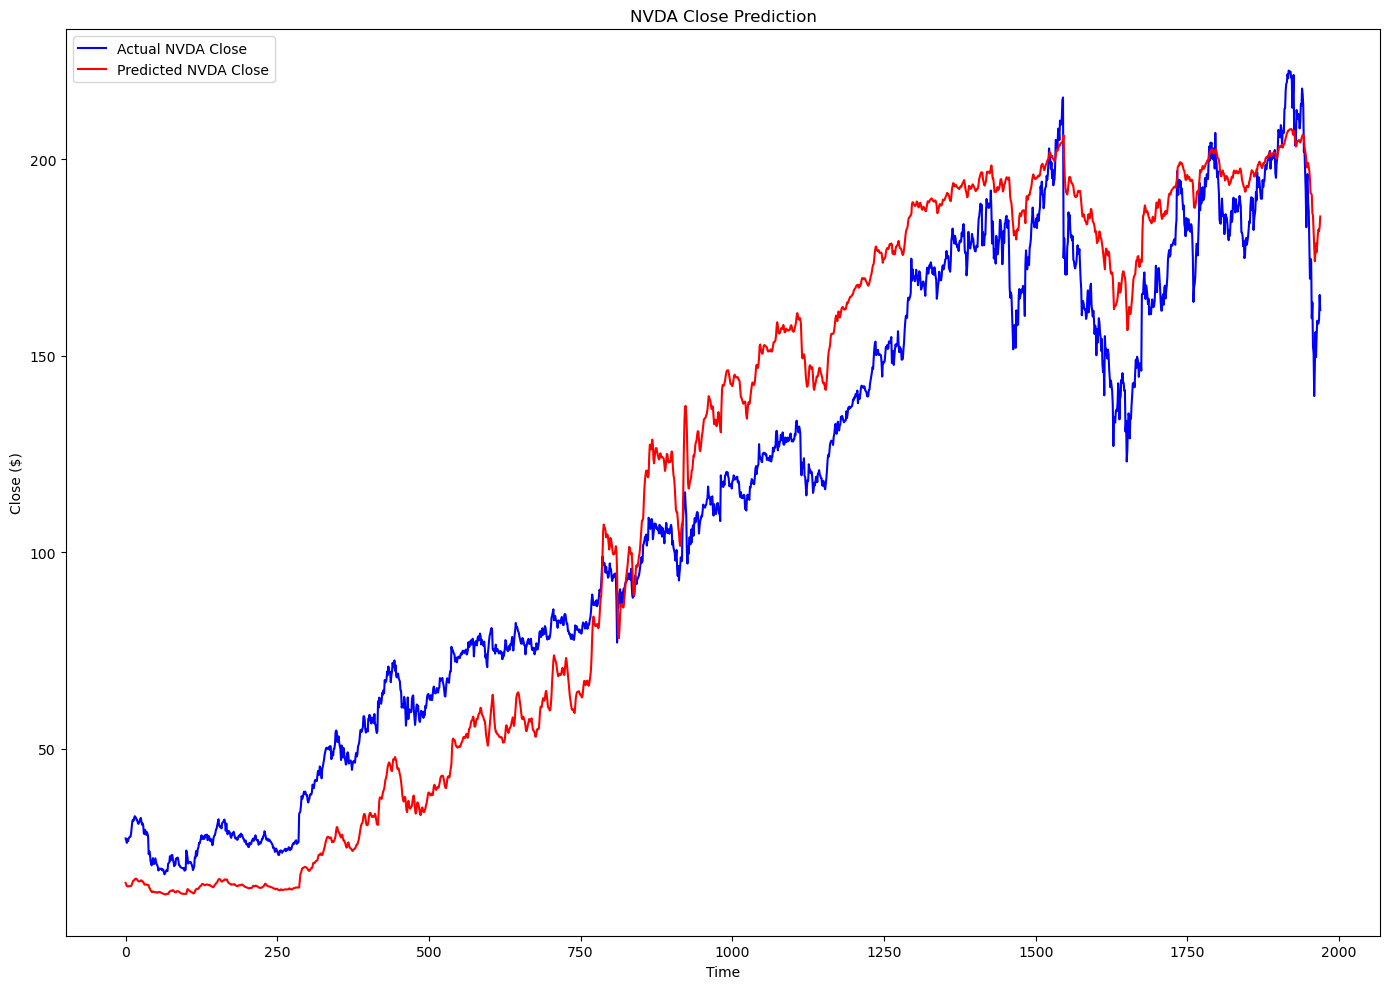

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import load_model
#model = models.load_model('mv2')

# Load the NVDA CSV file
nvda_df = pd.read_csv('./data/stocks/fb.csv')

# Ensure the 'Date' column is a datetime and set as index
nvda_df['Date'] = pd.to_datetime(nvda_df['Date'])
nvda_df.set_index('Date', inplace=True)

# Normalize the data
scaled_nvda = scaler.fit_transform(nvda_df)

# Check for NaN and infinity values
print("Checking for NaN values in data:", np.isnan(scaled_nvda).any())
print("Checking for infinity values in data:", np.isinf(scaled_nvda).any())

# Create dataset for NVDA
X_nvda, y_nvda = create_dataset(scaled_nvda, look_back)

# Make predictions for NVDA
nvda_predictions = model.predict(X_nvda)

# Inverse transform the predictions and the actual values
nvda_predictions_full = np.zeros_like(scaled_nvda)
nvda_actual_full = np.zeros_like(scaled_nvda)

nvda_predictions_full[look_back:look_back+len(nvda_predictions), -nvda_predictions.shape[1]:] = nvda_predictions
nvda_actual_full[look_back:look_back+len(y_nvda), -y_nvda.shape[1]:] = y_nvda

# Perform inverse transformation
nvda_predictions = scaler.inverse_transform(nvda_predictions_full)[look_back:look_back+len(nvda_predictions), -nvda_predictions.shape[1]:]
nvda_actual = scaler.inverse_transform(nvda_actual_full)[look_back:look_back+len(y_nvda), -y_nvda.shape[1]:]

# Select a section of the time for display
time_section = slice(0, 30000)  # Modify the slice as needed

# Plot the actual vs predicted values for NVDA
features = ['Close']  # Adjust this if your CSV has different column names

plt.figure(figsize=(14, 10))
for i, feature in enumerate(features):
    plt.subplot(len(features), 1, i+1)
    plt.plot(nvda_actual[time_section, i], color='blue', label=f'Actual NVDA {feature}')
    plt.plot(nvda_predictions[time_section, i], color='red', label=f'Predicted NVDA {feature}')
    plt.title(f'NVDA {feature} Prediction')
    plt.xlabel('Time')
    plt.ylabel(f'{feature} ($)')
    plt.legend()

plt.tight_layout()
plt.show()
